# Linear vs Circular, Normalized vs non-normalized correlations

In [1]:
# we should test linear vs circular to understand the differences
# the main difference in the new version was a bug as 
# the zero-padding for linear case does not work as long as you leave values on the 
# borders not zero. 
# see new normalize_intensity function that should take care of uneven illumination
# both between the frames and at different regions of the image A or B


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.registration import phase_cross_correlation
from skimage import feature
# from skimage.feature.phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from skimage.exposure import match_histograms

In [2]:
from openpiv.tools import imread
from pylab import *

In [3]:
from scipy.fft import rfft2, rfftn

In [4]:
from openpiv.pyprocess import find_subpixel_peak_position
from openpiv.pyprocess import normalize_intensity, fft_correlate_images

In [24]:
a = imread('EXP0_TRY000100.T000.D000.P000.H000.LB.TIF')
b = imread('EXP0_TRY000110.T000.D000.P000.H000.LB.TIF')
#a = a[:32,:32].copy()
a[16:18,16:18] = 255
# b = b[:32,:32]
b[16:18,16:18] = 255
# should be in the order of y,x:
# so it's about 5 pixels upwards and about 3 pixels to the right
#shift = (-12.035, -10.92)
# The shift corresponds to the pixel offset relative to the reference image
#b = fourier_shift(np.fft.fftn(a), shift)
#b = np.fft.ifftn(b).real
#b = match_histograms(b,a).astype('uint8')
# b = b + np.linspace(10,85,32)

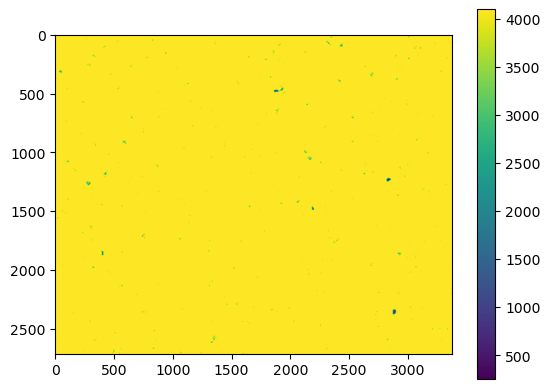

In [25]:
imshow(a)
colorbar()

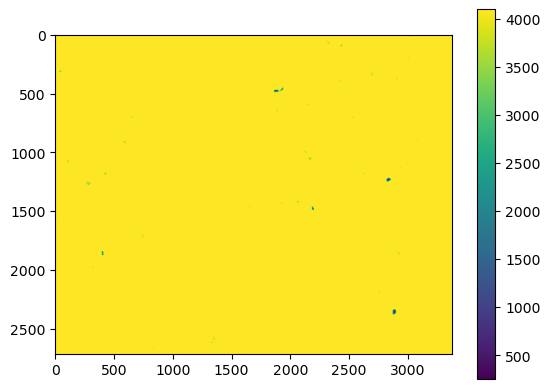

In [26]:
imshow(b)
colorbar()

In [27]:
# like moving window with the 0th dimension the IW no.
a = a[np.newaxis,:,:]
b = b[np.newaxis,:,:]

In [28]:
# %%timeit 
c1 = fft_correlate_images(a,b,'circular',normalized_correlation=False)

In [29]:
# %%timeit
c2 = fft_correlate_images(a,b,'linear',normalized_correlation=False)

In [30]:
# %%timeit
c3 = fft_correlate_images(a,b,'circular',normalized_correlation=True)

In [31]:
# %%timeit
c4 = fft_correlate_images(a,b,'linear',normalized_correlation=True)

Detected Peak Position: [1355.52540756 1687.81662029]
Computed Shift: [1355.52540756  331.81662029]
Detected Peak Position: [1355.99601686 1687.99812916]
Computed Shift: [1355.99601686  331.99812916]
Detected Peak Position: [1355.54906609 1687.7313845 ]
Computed Shift: [1355.54906609  331.7313845 ]
Detected Peak Position: [1355.90553103 1687.95249741]
Computed Shift: [1355.90553103  331.95249741]


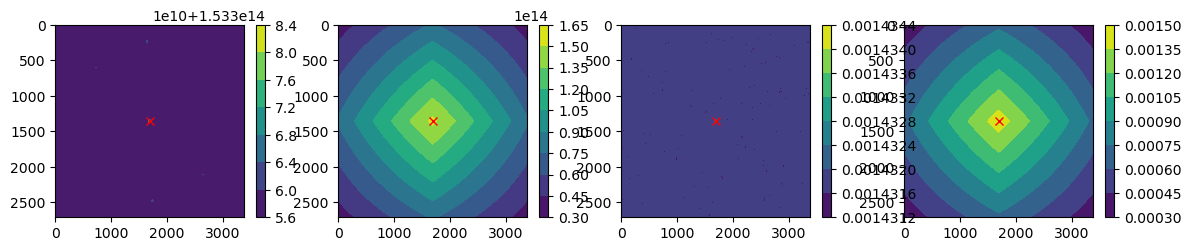

In [32]:
#find the shift 
fig, ax = plt.subplots(1, 4, figsize=(14, 2.5))

counter = 0
for c in [c1, c2, c3, c4]:
    s = ax[counter].contourf(c[0, :, :])
    ax[counter].invert_yaxis()
    colorbar(s, ax=ax[counter])

    default_peak_position = np.floor(np.array(a.shape) / 2)[:2]  # Take the first 2 elements
    i = np.array(find_subpixel_peak_position(c[0, :, :]))

    # Compute the shift based on the detected peak position
    shift = i - default_peak_position
    
    ax[counter].plot(i[1], i[0], 'rx')
    
    # Print the detected peak position and the computed shift
    print("Detected Peak Position:", i)
    print("Computed Shift:", shift)
    
    counter += 1



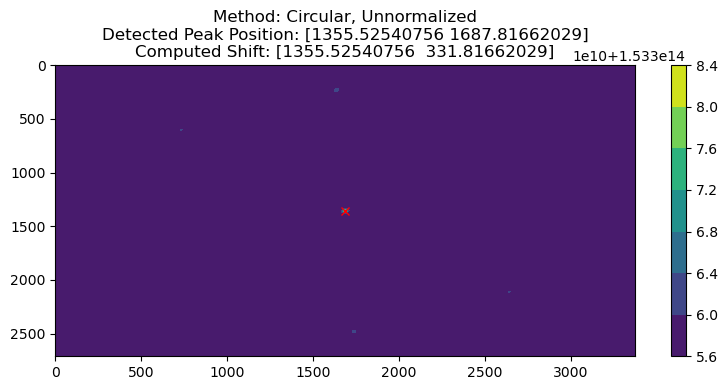

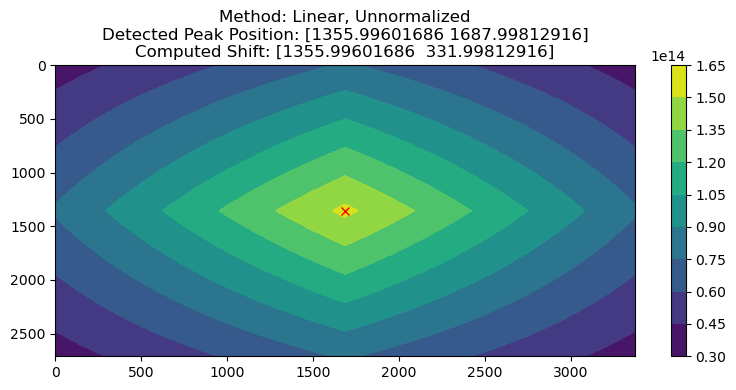

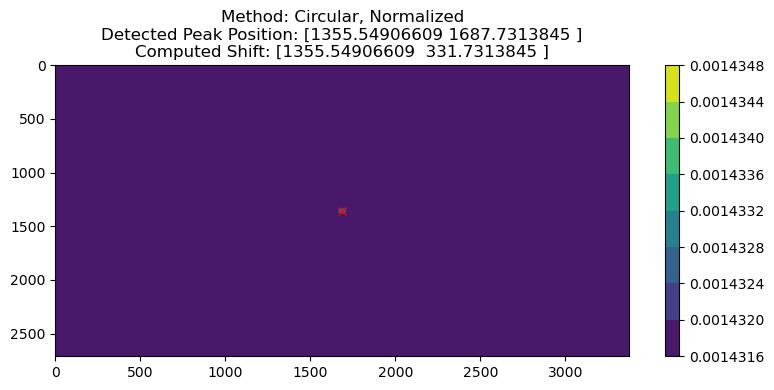

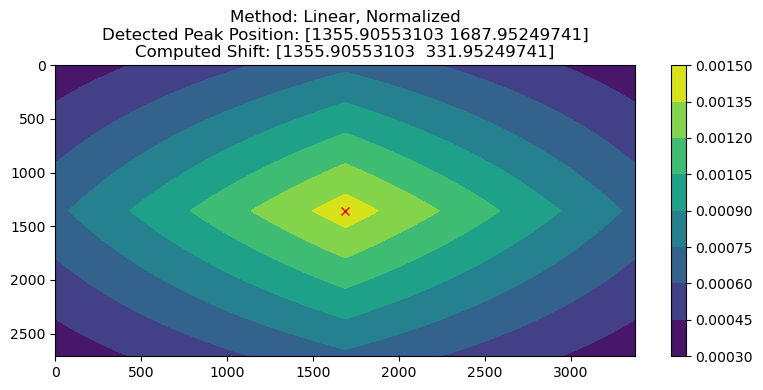

In [33]:
methods = ['Circular, Unnormalized', 'Linear, Unnormalized', 'Circular, Normalized', 'Linear, Normalized']

for method, c in zip(methods, [c1, c2, c3, c4]):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    s = ax.contourf(c[0, :, :])
    ax.invert_yaxis()
    colorbar(s, ax=ax)
    
    default_peak_position = np.floor(np.array(a.shape) / 2)[:2]  # Take the first 2 elements
    i = np.array(find_subpixel_peak_position(c[0, :, :]))

    # Compute the shift based on the detected peak position
    shift = i - default_peak_position
    
    ax.plot(i[1], i[0], 'rx')
    
    # Set title with method description
    ax.set_title(f'Method: {method}\nDetected Peak Position: {i}\nComputed Shift: {shift}')
    
    plt.tight_layout()
    plt.show()





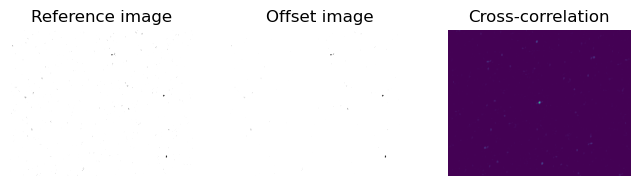

Detected pixel offset (y, x): [0. 0.]


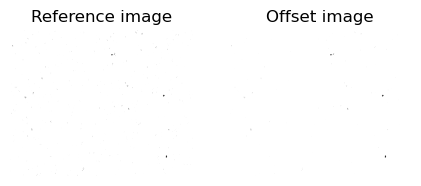

Detected subpixel offset (y, x): [-0.468 -0.18 ]


In [34]:
image = a[0,:,:]
offset_image = b[0,:,:]
# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image).conj() * np.fft.fft2(offset_image)
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

# subpixel precision
shift, error, diffphase = phase_cross_correlation(offset_image, image, upsample_factor=1000)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
# ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))